In [84]:
from __future__ import  division
import numpy as np
import pandas as pd
from collections import OrderedDict
import sys
import os
import pickle
from sklearn.metrics import roc_curve, auc, precision_recall_curve

sys.path.insert(0 , "../codes/")
from LRC.preprocessor_new import  LRC_preprocessor
from LRC.utils import  run_CV, plot_CV_perfomStat
from LRC.classifier import  LogReg_Continuous
from mCpG_to_feature import Gene_Methyldata 
from inspect import signature

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
##########################
## GLOBALS
outdir = "./"
conditions_fit = ["d1", "d2", "d3", "d4" ]
fit_types = ["d.plus0_DE.down_v_rest", "d.plus0_DE.up_v_rest" ]  
n_features = 30
extend_rel = 0.2
stdz_width = 0.1
start = -1*extend_rel
stop = 1.0 + extend_rel
multipleEntries = "sum" 
stdz_method =  "med_mad.above"
n_folds = 10
tanh_scale = 50.

np.random.seed(123)  

if not os.path.exists(outdir ):
    os.makedirs(outdir )

### Load data

In [3]:
###########################
## LOAD DATA
## GFF
gtf_file = "../genome/Annotation2/genes.gff"

### Load Genes split by DE transitions
f = open("../processed_RNAseq/DEseq2_removeBatch/timeCourse.geneDEflow.pkl", 'rb')
geneSets_byDay = pickle.load(f)
f.close()

### Load Metagene methylation
geneMethyl_byCond_fnames = OrderedDict([("d1", "../gene_methyl/3B13L-d1_mCpG.bayes_gene.extendRel.pklz"),
                                       ("d2", "../gene_methyl/3B13L-d2_mCpG.bayes_gene.extendRel.pklz" ), 
                                       ("d3",  "../gene_methyl/3B13L-d3_mCpG.bayes_gene.extendRel.pklz" ),
                                       ("d4",  "../gene_methyl/3B13L-d4_mCpG.bayes_gene.extendRel.pklz" )])
geneMethyl_byCond = OrderedDict([])
for cond , fname in geneMethyl_byCond_fnames.items():
    gene_methyl = Gene_Methyldata( gff_file= gtf_file  , feature_type = "gene", 
                               CpG_fns =  None , est_p = "p_bayes", 
                               chroms_allowed = ["chr1", "chr2" , "chr3", "chr4"],
                               est_p_kws = None)
    gene_methyl.load_mCpG_genes(fname )
    gene_methyl.extend_rel = extend_rel 
    geneMethyl_byCond[cond] = gene_methyl

Loading gff file ../genome/Annotation2/genes.gff
Loading gff file ../genome/Annotation2/genes.gff
Loading gff file ../genome/Annotation2/genes.gff
Loading gff file ../genome/Annotation2/genes.gff


### CV 

#### CV - make datasets

In [4]:
#################################################################################
## Make CV dataset

for ft in fit_types:
    print("working on fit type {}".format(ft))
    ## Create preprocessor object and dataframe for standardization parameters 
    lrc_pp = LRC_preprocessor( n_features = n_features, start = start, stop = stop, stdz_width = stdz_width,
                             multipleEntries = multipleEntries, stdz_method =stdz_method  , n_process = 12)  
    stdz_params_all = pd.DataFrame(columns = ["bin_lbound","bin_ubound","mean","std","stdz_name","fold"],
                              index = [], dtype = float).astype({"stdz_name": str , "fold": str} )
    for cond in conditions_fit: 
        print("\tworking on condition {}".format(cond ) )
        gene_methyldata = geneMethyl_byCond[cond]
        if ft == "d.plus0_DE.down_v_rest":  
            class0 = OrderedDict([ (g,  pd.DataFrame( data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                        gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                                        columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.neither"]['genes'].union(geneSets_byDay[cond]["DE.up"]['genes']) 
                                  if g in gene_methyldata.mCpG_genes.keys()  
                               ])
            class1 = OrderedDict([ (g, pd.DataFrame( data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                             columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.down"]['genes']  \
                                  if g in gene_methyldata.mCpG_genes.keys()
                               ])
        elif ft  == "d.plus0_DE.up_v_rest":  
            class0 = OrderedDict([ (g,  pd.DataFrame( data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                             columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.neither"]['genes'].union(geneSets_byDay[cond]["DE.down"]['genes'] ) 
                                  if g in gene_methyldata.mCpG_genes.keys()
                                  ])
            class1 = OrderedDict([ (g,  pd.DataFrame( data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                             columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.up"]['genes']  \
                                  if g in gene_methyldata.mCpG_genes.keys()
                                 ])
        else:
            raise ValueError("ft value \'{}\' not recognized".format(ft))

        stdz_params_CV = lrc_pp.add_CV_datasets(OrderedDict([ ("class0", class0) , ("class1" , class1) ]),
                                                n_folds = n_folds, stdz_name = cond, tanh_scale = tanh_scale  )
        stdz_params_CV.index = pd.MultiIndex.from_product( [  (cond,),  stdz_params_CV.index.values  ] )
        stdz_params_all = pd.concat([ stdz_params_all , stdz_params_CV ], axis = 0)
        
        
    dataset= lrc_pp.dataset.copy()
    dataset[("feature_categ", "day")] = dataset[("metaData", "stdz_name")].copy()
    dataset= (dataset[["feature_categ","feature", "metaData"]]).rename(columns = {"feature_categ" : "feature"}, level = 0)    
    ## write results
    dataset.to_csv(os.path.join(outdir , "CV_LRC.in_{}.tsv.gz".format(ft) ), sep = "\t", compression = 'gzip', index = False)
    stdz_params_all.to_csv(os.path.join(outdir , "CV_LRC.in_stdzParams_{}.tsv.gz".format(ft) ), sep = "\t", compression = 'gzip', index= False) 


working on fit type d.plus0_DE.down_v_rest
	working on condition d1
OrderedDict([(0, 527), (1, 527), (2, 527), (3, 527), (4, 527), (5, 527), (6, 527), (7, 527), (8, 527), (9, 518)])
[3170, 1564]
[3161, 1573]
[3174, 1560]
[3157, 1577]
[3172, 1562]
[3177, 1557]
[3167, 1567]
[3153, 1581]
[3182, 1552]
[3176, 1567]
	working on condition d2
OrderedDict([(0, 527), (1, 527), (2, 527), (3, 527), (4, 527), (5, 527), (6, 527), (7, 527), (8, 527), (9, 518)])
[3408, 1326]
[3407, 1327]
[3413, 1321]
[3397, 1337]
[3402, 1332]
[3413, 1321]
[3403, 1331]
[3422, 1312]
[3405, 1329]
[3440, 1303]
	working on condition d3
OrderedDict([(0, 527), (1, 527), (2, 527), (3, 527), (4, 527), (5, 527), (6, 527), (7, 527), (8, 527), (9, 518)])
[3938, 796]
[3931, 803]
[3936, 798]
[3930, 804]
[3943, 791]
[3937, 797]
[3942, 792]
[3944, 790]
[3941, 793]
[3951, 792]
	working on condition d4
OrderedDict([(0, 527), (1, 527), (2, 527), (3, 527), (4, 527), (5, 527), (6, 527), (7, 527), (8, 527), (9, 518)])
[4459, 275]
[4449, 28

### CV run `"d.plus0_DE.down_v_rest"`

In [3]:
ft = "d.plus0_DE.down_v_rest"
fo = "CV_d.plus0_DE.down_v_rest" 
outdir = "."
penalties = np.logspace( -5 , 1, base = 10, num= 7)
performStats= ["acc" , "auROC", "auPRC", "auPRC_baseline" ]
conditions_fit = ["d1", "d2", "d3", "d4" ]

In [16]:
##Load data 
datasets_all = pd.read_csv( os.path.join(outdir,"CV_LRC.in_{}.tsv.gz".format(ft)), sep = "\t",compression = "gzip", header=[0,1]) 
datasets_all = datasets_all.rename(columns = lambda x: float(x) if (x[0].isdigit() or x[0] == "-") else x , level = 1 )
CV_data  = datasets_all.copy()
display(CV_data.head())

feature                                                              \
      day    -0.177     -0.13    -0.083    -0.037      0.01     0.057   
0      d1  0.000000 -0.014415  0.000000  0.000000  0.000000  0.000000   
1      d1  0.035302  0.000000  0.000000  0.000000  0.000000  0.001790   
2      d1  0.008997  0.374933  0.307079  0.000000 -0.022954 -0.053952   
3      d1  0.471970  0.651553  0.393838  0.478161  0.000000  0.112273   
4      d1  0.507159  0.119587  0.065502  0.085438  0.050810  0.109324   

                                ...                                          \
      0.103      0.15     0.197 ...     1.037     1.083      1.13     1.177   
0  0.000000  0.000000  0.000000 ...  0.000000  0.000000  0.000000  0.000000   
1  0.420666  0.000000  0.000000 ...  0.000000  0.000000  0.403840  0.000000   
2 -0.081517  0.000000 -0.022799 ...  0.604704  0.009186  0.000000  0.000000   
3  0.586492  1.349731  0.061642 ...  0.535355  0.000000 -0.017875  0.208534   
4  0.347293  0.605790 -0.072390 ...  0.191686 -0.148317  0.109693  0.000000   

  metaData                                         
  cls_name fold    geneID stdz_name train/test  y  
0   class0    0  gene1221        d1      train  0  
1   class0    0   gene950        d1      train  0  
2   class0    0  gene2464        d1      train  0  
3   class0    0  gene3002        d1      train  0  
4   class0    0   gene582        d1      train  0  

[5 rows x 37 columns]

In [17]:
## Run CV and extract test set preds
CV_results, preds_dict = run_CV(CV_data, categ_feature = "day", lmbda_vals= penalties, categ_levels_measure=conditions_fit, return_preds = True )

## Combine preds_dict into single data frame with 1 entry for each gene day pair - storing prediction when that gene, day pair was in holdout set
preds_df_list = []
for penalty , df in preds_dict.items():
    day = df["feature"][ conditions_fit ].idxmax(axis = 1)
    day.name = "day"
    combined =  pd.concat( [df["metaData"] , day], axis =1 )
    combined["penalty"] = penalty
    preds_df_list.append( combined  )
preds_df = pd.concat( preds_df_list, axis = 0 , ignore_index =True )

In [18]:
CV_results.to_csv( fo + "_performStats.tsv" , sep = "\t")
preds_df.to_csv( fo + "_preds.test.tsv.gz" , sep = "\t", compression = "gzip")  ## Predictions on test set will be used to compare perfermance on GO enriched /non-GO enriched genes

### CV - plot performance `"d.plus0_DE.down_v_rest"`

/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4327: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


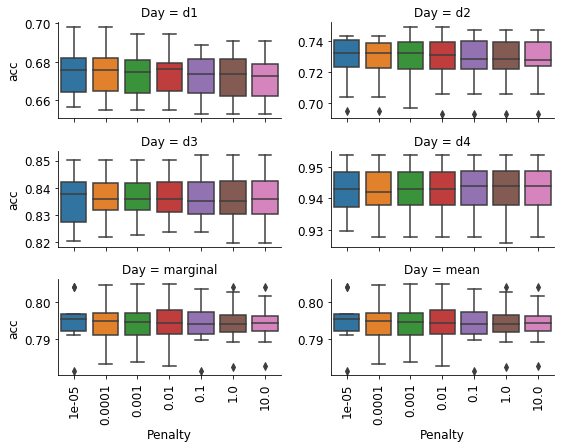

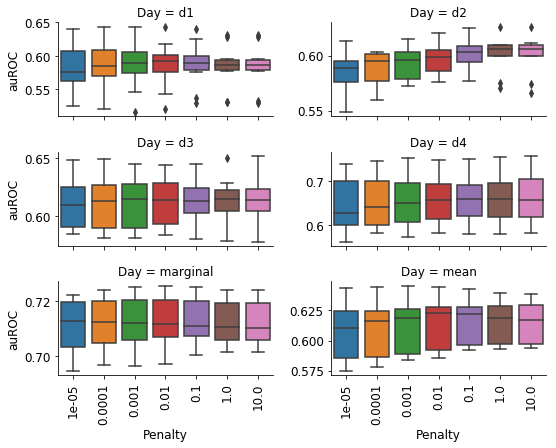

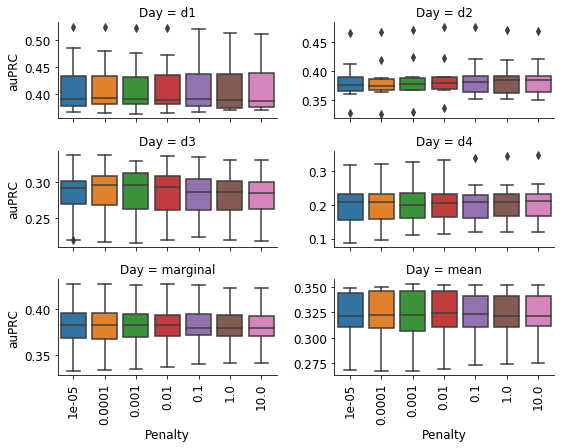

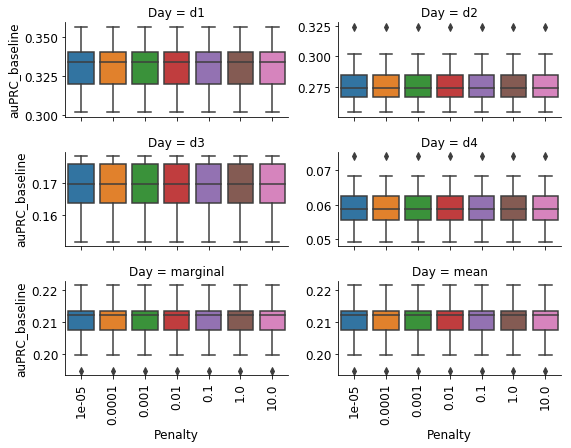

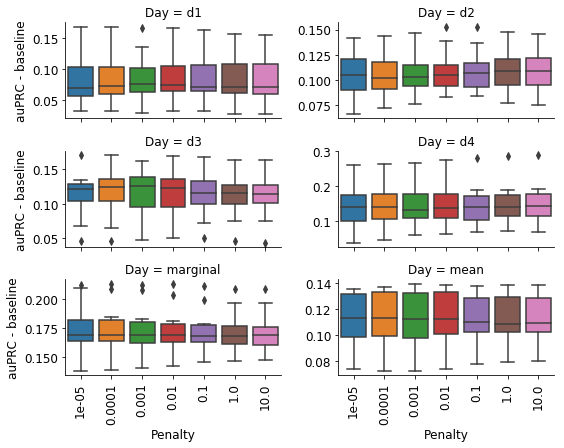

In [19]:
## PLOT
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12

for stat_name in performStats:
    plotData = CV_results[stat_name].copy()
    ## add mean over days to plot 
    plotData_avg = plotData.groupby( axis = 1, level = 0).apply( lambda x:  ( x.sum(axis = 1) - x[(x.name,  "marginal")]) / ( x.shape[1] -1 )  )
    plotData_avg.columns = pd.MultiIndex.from_product( [plotData_avg.columns , ("mean",)] )
    plotData = plotData.join(plotData_avg).sort_index(axis = 1)
    g = plot_CV_perfomStat( plotData, stat_name = stat_name, groupby_day = True ,
                                aspect =2, col_wrap = 2, sharey=False )
    g.savefig( fo + "_boxPlot.{}.pdf".format(stat_name) , format = "pdf" )
    
if ("auPRC" in performStats) and ( "auPRC_baseline" in performStats):
    plotData = CV_results["auPRC"].copy()
    plotData =  plotData  - CV_results["auPRC_baseline"].copy()
    ## add mean over days to plot 
    plotData_avg = plotData.groupby( axis = 1, level = 0).apply( lambda x:  ( x.sum(axis = 1) - x[(x.name,  "marginal")]) / ( x.shape[1] -1 )  )
    plotData_avg.columns = pd.MultiIndex.from_product( [plotData_avg.columns , ("mean",)] )
    plotData = plotData.join(plotData_avg).sort_index(axis = 1)
    g = plot_CV_perfomStat( plotData, stat_name = "auPRC - baseline",groupby_day = True ,
                                aspect =2, col_wrap = 2, sharey=False )
    g.savefig(fo + "_boxPlot.{}.pdf".format("auPRC - baseline") , format = "pdf" )

### CV run `"d.plus0_DE.up_v_rest"`

In [20]:
ft = "d.plus0_DE.up_v_rest"
fo = "CV_d.plus0_DE.up_v_rest" 

penalties = np.logspace( -5 , 1, base = 10, num= 7)
performStats= ["acc" , "auROC", "auPRC", "auPRC_baseline" ]
outdir = "."
conditions_fit = ["d1", "d2", "d3", "d4" ]

In [21]:
print(penalties)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


In [22]:
##Load data 
datasets_all = pd.read_csv( os.path.join(outdir,"CV_LRC.in_{}.tsv.gz".format(ft)), sep = "\t",compression = "gzip", header=[0,1]) 
datasets_all = datasets_all.rename(columns = lambda x: float(x) if (x[0].isdigit() or x[0] == "-") else x , level = 1 )
CV_data  = datasets_all.copy()
display(CV_data.head())


feature                                                              \
      day    -0.177     -0.13    -0.083    -0.037      0.01     0.057   
0      d1 -0.012095 -0.012095  0.000000  0.012291  0.000000 -0.031561   
1      d1  0.332478  0.214892 -0.076521 -0.221602  0.359747  1.208416   
2      d1  0.035302  0.000000  0.000000  0.000000  0.000000  0.001790   
3      d1  0.471970  0.651553  0.393838  0.478161  0.000000  0.112273   
4      d1  0.507159  0.119587  0.065502  0.085438  0.050810  0.109324   

                                ...                                          \
      0.103      0.15     0.197 ...     1.037     1.083      1.13     1.177   
0 -0.020561 -0.057646  0.000000 ... -0.010034  0.013600  0.018251  0.000000   
1  0.379382 -0.103956  0.265560 ...  0.897848  0.002611  0.268717 -0.080213   
2  0.420666  0.000000  0.000000 ...  0.000000  0.000000  0.403840  0.000000   
3  0.586492  1.349731  0.061642 ...  0.535355  0.000000 -0.017875  0.208534   
4  0.347293  0.605790 -0.072390 ...  0.191686 -0.148317  0.109693  0.000000   

  metaData                                         
  cls_name fold    geneID stdz_name train/test  y  
0   class0    0  gene4407        d1      train  0  
1   class0    0  gene4401        d1      train  0  
2   class0    0   gene950        d1      train  0  
3   class0    0  gene3002        d1      train  0  
4   class0    0   gene582        d1      train  0  

[5 rows x 37 columns]

In [23]:
## Run CV and extract test set preds
CV_results, preds_dict = run_CV(CV_data, categ_feature = "day", lmbda_vals= penalties, categ_levels_measure=conditions_fit, return_preds = True )

## Combine preds_dict into single data frame with 1 entry for each gene day pair - storing prediction when that gene, day pair was in holdout set
preds_df_list = []
for penalty , df in preds_dict.items():
    day = df["feature"][ conditions_fit ].idxmax(axis = 1)
    day.name = "day"
    combined =  pd.concat( [df["metaData"] , day], axis =1 )
    combined["penalty"] = penalty
    preds_df_list.append( combined  )
preds_df = pd.concat( preds_df_list, axis = 0 , ignore_index =True )

In [24]:
CV_results.to_csv( fo + "_performStats.tsv" , sep = "\t")
preds_df.to_csv( fo + "_preds.test.tsv.gz" , sep = "\t", compression = "gzip") ## Predictions on test set will be used to compare perfermance on GO enriched /non-GO enriched genes

/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4327: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


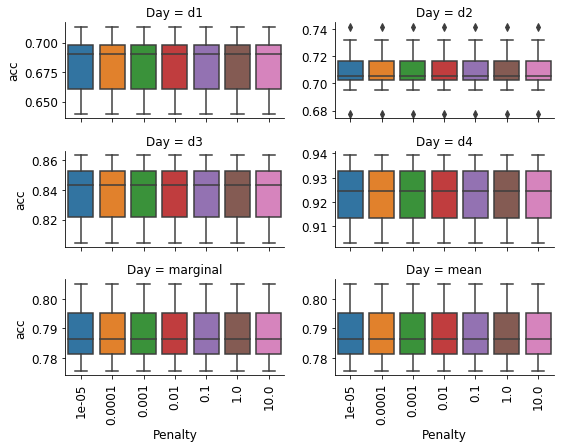

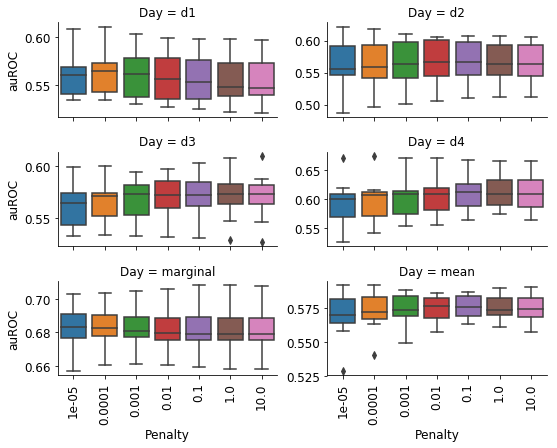

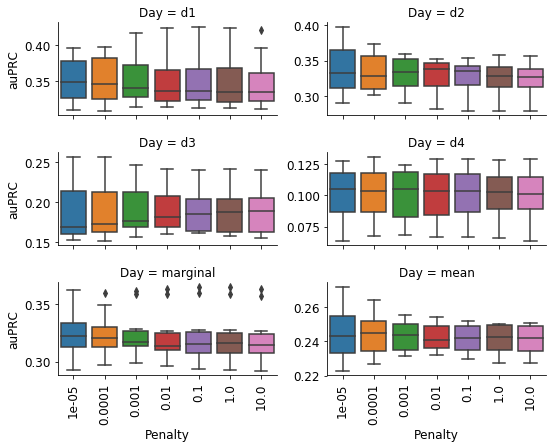

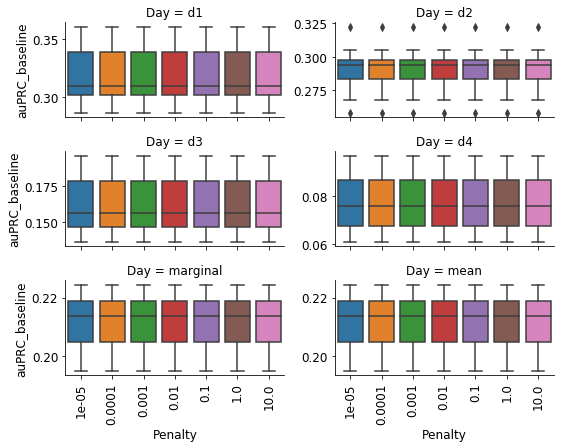

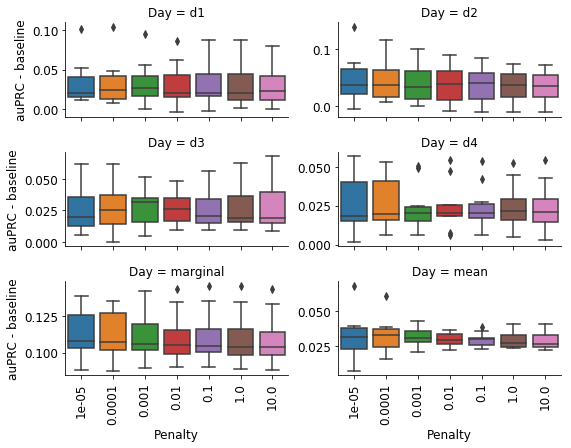

In [26]:
## Plot 
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12

for stat_name in performStats:
    plotData = CV_results[stat_name].copy()
    ## add mean over days to plot 
    plotData_avg = plotData.groupby( axis = 1, level = 0).apply( lambda x:  ( x.sum(axis = 1) - x[(x.name,  "marginal")]) / ( x.shape[1] -1 )  )
    plotData_avg.columns = pd.MultiIndex.from_product( [plotData_avg.columns , ("mean",)] )
    plotData = plotData.join(plotData_avg).sort_index(axis = 1)
    g = plot_CV_perfomStat( plotData, stat_name = stat_name, groupby_day = True ,
                                aspect =2, col_wrap = 2, sharey=False )
    g.savefig( fo + "_boxPlot.{}.pdf".format(stat_name) , format = "pdf" )
    
if ("auPRC" in performStats) and ( "auPRC_baseline" in performStats):
    plotData = CV_results["auPRC"].copy()
    plotData =  plotData  - CV_results["auPRC_baseline"].copy()
    ## add mean over days to plot 
    plotData_avg = plotData.groupby( axis = 1, level = 0).apply( lambda x:  ( x.sum(axis = 1) - x[(x.name,  "marginal")]) / ( x.shape[1] -1 )  )
    plotData_avg.columns = pd.MultiIndex.from_product( [plotData_avg.columns , ("mean",)] )
    plotData = plotData.join(plotData_avg).sort_index(axis = 1)
    g = plot_CV_perfomStat( plotData, stat_name = "auPRC - baseline",groupby_day = True ,
                                aspect =2, col_wrap = 2, sharey=False )
    g.savefig(fo + "_boxPlot.{}.pdf".format("auPRC - baseline") , format = "pdf" )